In [1]:
import numpy as np;
import pandas as pd;

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer,roc_auc_score,precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
!pip install --upgrade scikit-learn
roc_auc_scoreScorer=make_scorer(roc_auc_score)
mccScorer = make_scorer(matthews_corrcoef)
from numpy import mean
from numpy import std

from google.colab import drive
drive.mount("/content/gdrive")

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler

Mounted at /content/gdrive


In [2]:
#read training dataset 1
data1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_1_Training.csv')

X_train_actual_1=data1[:-2].T[1:].values

y_train_actual_1 = data1[-2:].T[-130:].T.values

In [3]:
#read training dataset 2
data2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_2_Training.csv')

X_train_actual_2=data2[:-4].T[1:].values

y_train_actual_2 = data2[-4:].T[-340:].T.values

In [4]:
co1={'X':X_train_actual_1,'Y': y_train_actual_1[0]};
co2={'X':X_train_actual_1,'Y': y_train_actual_1[1]};

co3={'X':X_train_actual_2,'Y': y_train_actual_2[0]};
co4={'X':X_train_actual_2,'Y': y_train_actual_2[1]};
co5={'X':X_train_actual_2,'Y': y_train_actual_2[2]};
co6={'X':X_train_actual_2,'Y': y_train_actual_2[3]};

In [ ]:
def determine_number_of_top_features(X,Y):
  X=pd.DataFrame(X)
  X=X.astype(float)

  Y=pd.DataFrame(Y)
  Y=Y.astype(int)

  sel = f_classif(X, Y)
  p_values = pd.Series(sel[1])
  p_values.index = X.columns
  p_values.sort_values(ascending=True, inplace=True)
  p_values = p_values[p_values < 0.05]
  X_p = X[p_values.index]
  return X_p.shape[1]

In [ ]:
best_co1=determine_number_of_top_features(**co1)
best_co2=determine_number_of_top_features(**co2)
best_co3=determine_number_of_top_features(**co3)
best_co4=determine_number_of_top_features(**co4)
best_co5=determine_number_of_top_features(**co5)
best_co6=determine_number_of_top_features(**co6)

In [ ]:
def KNN_with_HPTuning(X,Y):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X.astype(np.float32))

  # define models and parameters
  model = KNeighborsClassifier()
  n_neighbors = range(1, 21, 2)
  weights = ['uniform', 'distance']
  metric = ['euclidean', 'manhattan', 'minkowski']
  # define grid search
  grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=mccScorer)
  result = grid_search.fit(X_train_scaled, Y.astype('int'))
  # summarize result
  print('Best Score: %s' % result.best_score_)
  print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
KNN_with_HPTuning(**co1)

Best Score: 0.4394986463384648
Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}


In [ ]:
KNN_with_HPTuning(**co2)

Best Score: 0.33466836909782927
Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


In [ ]:
KNN_with_HPTuning(**co3)

Best Score: 0.18418319409534886
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


In [ ]:
KNN_with_HPTuning(**co4)

Best Score: 0.10206572191217538
Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


In [ ]:
KNN_with_HPTuning(**co5)

Best Score: 0.04631206373223307
Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}


In [ ]:
KNN_with_HPTuning(**co6)

Best Score: 0.06967038143250963
Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


In [ ]:
def feature_selector(X,Y,numberOfFeaturesToBeSelected=1):
  if(numberOfFeaturesToBeSelected == 1):
    totalNumberOfFeatures=X.shape[1]
    numberOfFeaturesToBeSelected=totalNumberOfFeatures//2;
  # define feature selection
  fs = SelectKBest(score_func=f_classif, k=numberOfFeaturesToBeSelected)
  # apply feature selection
  return fs.fit(X, Y)

In [ ]:
def plot_PRC_for_CV(predictor,k_fold,X,y,label):
  f, axes = plt.subplots(1,1,squeeze=False)
  
  y_real = []
  y_proba = []
  
  for i, (train_index, test_index) in enumerate(k_fold.split(X,y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes[0,0].step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

  y_real = np.concatenate(y_real)
  y_proba = np.concatenate(y_proba)
  precision, recall, _ = precision_recall_curve(y_real, y_proba)
  lab = 'Overall AUC=%.4f' % (auc(recall, precision))
  axes[0,0].step(recall, precision, label=lab, lw=2, color='black')
  axes[0,0].set_xlabel('Recall')
  axes[0,0].set_ylabel('Precision')
  axes[0,0].legend(loc='lower left', fontsize='small')
  axes[0,0].set(title=label)

  # f.tight_layout()
  f.savefig(label+'.png')

In [ ]:
def plot_ROC_for_CV(classifier,cv,X,y,label):
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = RocCurveDisplay.from_estimator(
          classifier,
          X[test],
          y[test],
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      title=label,
  )
  ax.legend(loc="lower right")
  plt.show()
  fig.savefig(label+'.png')

In [ ]:
def KNN_with_cross_validation(X,Y,n_neighbors,endpointLabel,numberOfFeatures=1,weights='uniform',metric='minkowski'):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X.astype(np.float32))

  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1','ruc_auc':roc_auc_scoreScorer}
  
  # define model
  model = KNeighborsClassifier(weights=weights,metric=metric,n_neighbors=n_neighbors)
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

  X_selected_features=feature_selector(X_train_scaled,Y,numberOfFeaturesToBeSelected=numberOfFeatures).transform(X_train_scaled);
  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print(model.get_params())
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-KNN-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-KNN-'+endpointLabel)

In [ ]:
KNN_with_cross_validation(co1['X'],co1['Y'],7,'CO1',best_co1)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
MCC Score- Mean: 0.600 SD: (0.164)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.00226574 0.01177535 0.59982661 0.79230769 0.72929487 0.82727273
 0.76426203 0.79655303]
SD [0.00025557 0.00139306 0.1637778  0.07919715 0.13930943 0.1318652
 0.09391401 0.07827012]


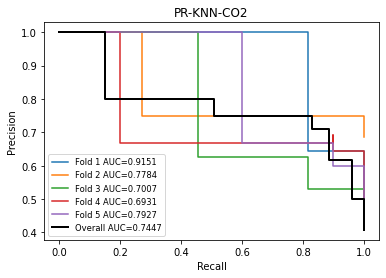

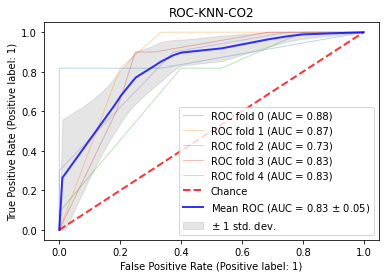

In [24]:
KNN_with_cross_validation(co2['X'],co2['Y'],5,'CO2',best_co2)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
MCC Score- Mean: 0.235 SD: (0.073)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.02155933 0.05584035 0.23511705 0.75882353 0.52463925 0.25367647
 0.33855901 0.5878865 ]
SD [0.00063804 0.00657511 0.0726539  0.02564058 0.10061997 0.04776583
 0.05292635 0.02620887]


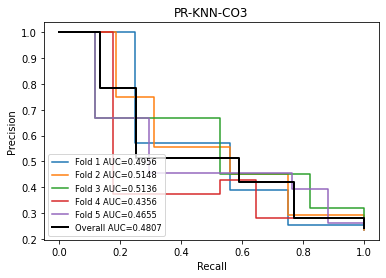

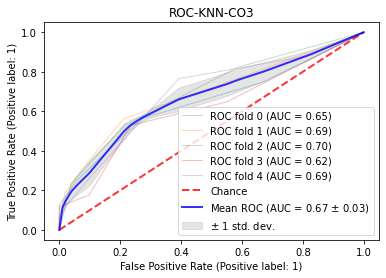

In [26]:
KNN_with_cross_validation(co3['X'],co3['Y'],5,'CO3',best_co3)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
MCC Score- Mean: 0.187 SD: (0.109)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.01697545 0.03317599 0.18657108 0.84117647 0.59       0.11636364
 0.1812987  0.54260408]
SD [0.00325615 0.00125544 0.10851297 0.02352941 0.34985711 0.03272727
 0.04704606 0.02064143]


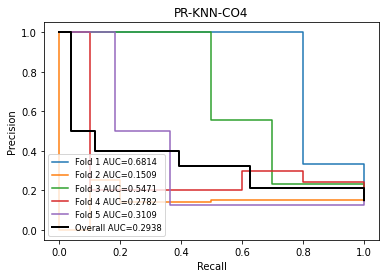

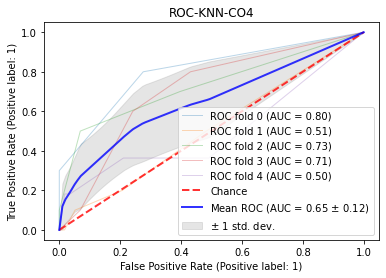

In [33]:
KNN_with_cross_validation(co4['X'],co4['Y'],5,'CO4',best_co4)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
MCC Score- Mean: 0.432 SD: (0.156)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.00618863 0.0263886  0.43246502 0.72647059 0.75044419 0.5262069
 0.61624792 0.70143003]
SD [0.00062079 0.00308233 0.15625802 0.06997281 0.0997401  0.12504648
 0.12220302 0.07782062]


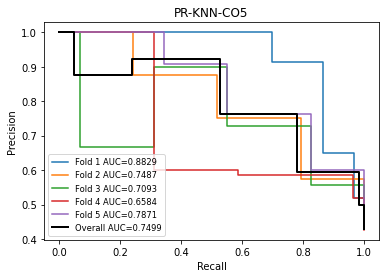

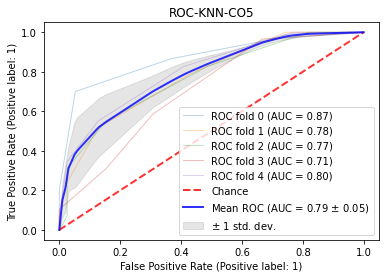

In [29]:
KNN_with_cross_validation(co5['X'],co5['Y'],5,'CO5',best_co5)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
MCC Score- Mean: 0.212 SD: (0.110)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.00691314 0.02384038 0.2124567  0.63529412 0.64868133 0.84
 0.73027174 0.59142857]
SD [0.0004475  0.00055017 0.10973729 0.04499135 0.03824033 0.06244998
 0.03138439 0.05295358]


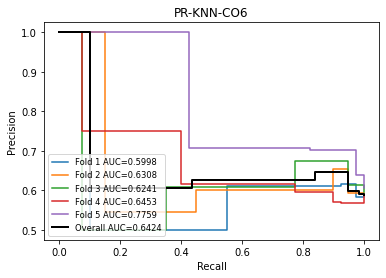

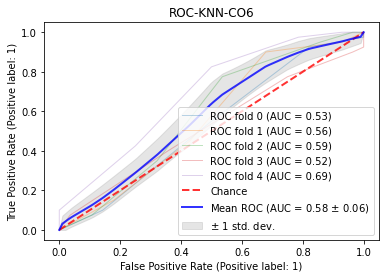

In [34]:
KNN_with_cross_validation(co6['X'],co6['Y'],5,'CO6',best_co6)